In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [7]:
train=pd.read_csv("./flight_delays_train.csv.zip")
test=pd.read_csv("./flight_delays_test.csv.zip")

In [8]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [9]:
data=pd.concat([train,test],ignore_index=True)

In [10]:
train.info()
print('-'*45)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000

In [11]:
train['dep_delayed_15min'].loc[train.dep_delayed_15min=='N']=0
train['dep_delayed_15min'].loc[train.dep_delayed_15min=='Y']=1
data['dep_delayed_15min'].loc[data.dep_delayed_15min=='N']=0
data['dep_delayed_15min'].loc[data.dep_delayed_15min=='Y']=1

In [12]:
data['Month']=data['Month'].str.replace('c-','')
data['Month']=data['Month'].str.replace('c-','')
train['Month']=train['Month'].str.replace('c-','')
train['Month']=train['Month'].str.replace('c-','')
data['DayofMonth']=data['DayofMonth'].str.replace('c-','')
data['DayofMonth']=data['DayofMonth'].str.replace('c-','')
train['DayofMonth']=train['DayofMonth'].str.replace('c-','')
train['DayofMonth']=train['DayofMonth'].str.replace('c-','')
data['DayOfWeek']=data['DayOfWeek'].str.replace('c-','')
data['DayOfWeek']=data['DayOfWeek'].str.replace('c-','')
train['DayOfWeek']=train['DayOfWeek'].str.replace('c-','')
train['DayOfWeek']=train['DayOfWeek'].str.replace('c-','')

<AxesSubplot:xlabel='Month', ylabel='count'>

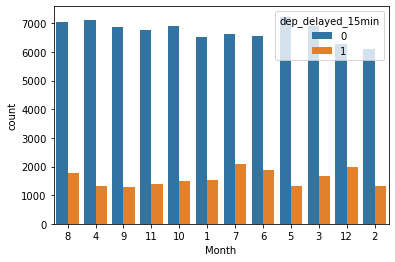

In [13]:
sns.countplot(x='Month',hue='dep_delayed_15min',data=train)

<AxesSubplot:xlabel='DayOfWeek', ylabel='count'>

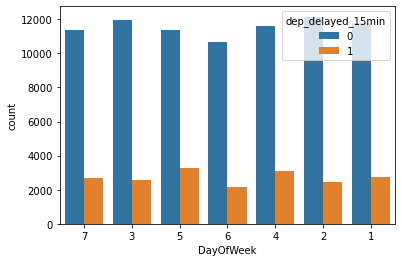

In [14]:
sns.countplot(x='DayOfWeek',hue='dep_delayed_15min',data=train)

<AxesSubplot:xlabel='DayOfWeek', ylabel='count'>

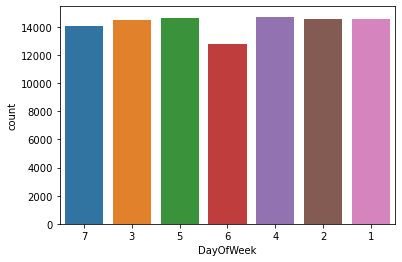

In [15]:
sns.countplot(x='DayOfWeek',data=train)

In [16]:
train['UniqueCarrier'].value_counts()

WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO     4334
EV     3930
FL     3039
AS     2222
YV     2128
B6     1838
HP     1378
F9     1006
DH      966
HA      762
TZ      446
AQ      234
Name: UniqueCarrier, dtype: int64

<AxesSubplot:xlabel='UniqueCarrier', ylabel='count'>

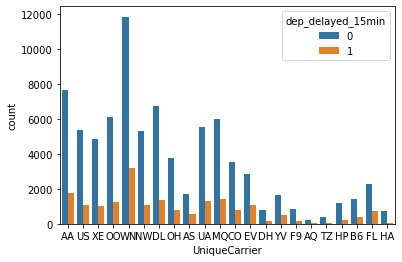

In [17]:
sns.countplot(x='UniqueCarrier',hue='dep_delayed_15min',data=train)

In [18]:
train['dep_hour']=train["DepTime"]//100
data['dep_hour']=data['DepTime']//100
train['dep_minute']=train["DepTime"]%100
data['dep_min']=data['DepTime']%100
data['dep_hour']=data['dep_hour'].replace([24,25],0)
train['dep_hour']=train['dep_hour'].replace([24,25],0)

<AxesSubplot:xlabel='dep_hour', ylabel='count'>

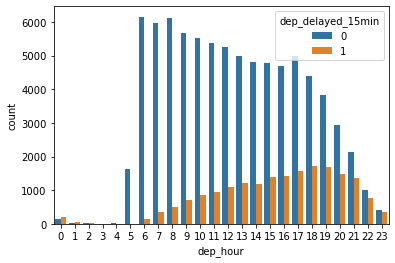

In [19]:
sns.countplot(x='dep_hour',hue='dep_delayed_15min',data=train)

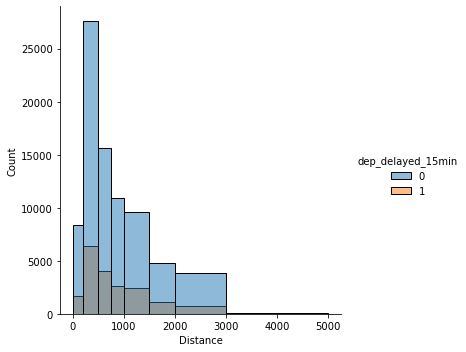

In [20]:
sns.displot(x='Distance',hue='dep_delayed_15min',bins=[0,200,500,750,1000,1500,2000,3000,4000,5000],data=train)

<AxesSubplot:xlabel='DayofMonth', ylabel='count'>

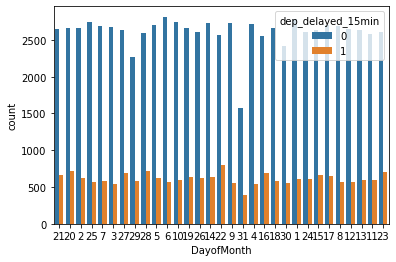

In [21]:
sns.countplot(x='DayofMonth',hue='dep_delayed_15min',data=train)

In [22]:
data['Route']=data['Origin'].astype('str')+'_'+data['Dest'].astype('str')
data['holidays']=(data['Month'].astype(int).isin([7,8,12])).astype(int)
data['last_month_days']=(data['DayofMonth'].astype(int).isin(range(20,25))).astype(int)
data["hour_squared"]=data['dep_hour']**2
data['distance_comment']='short'
data.loc[(data.Distance>500)&(data.Distance<2000),'distance_comment']='medium'
data.loc[(data.Distance>=2000),'distance_comment']='long'

In [23]:
data.drop(labels='DepTime',inplace=True,axis=1)
data.drop(labels='dep_min',inplace=True,axis=1)
data.drop(['DayofMonth'],axis=1,inplace=True)

In [24]:
new_train=data.iloc[:100000]
new_test=data.iloc[100000:]
new_test.drop('dep_delayed_15min',axis=1,inplace=True)

In [25]:
class CFG :
    SEED=42
    n_splits=5
    catboost_params = {'learning_rate':0.05,'iterations':10000,'eval_metric':'AUC',
                      'use_best_model' :True,'verbose':100,'random_seed': 0,
                      'devices':'0:1','task_type':"GPU",}
    lgb_params = {'boosting_type': 'gbdt','objective': 'binary','metric': 'auc',
                'n_estimators': 500,'sub_sample' : 0.7,'colsample_bytree' : 0.6,
                'seed': SEED,'silent':False,'early_stopping_rounds': 100,
               }
    categ_features = ['UniqueCarrier', 'Origin', 'Dest','Route', 'holidays', 'last_month_days','distance_comment']
    TARGET_COL = 'dep_delayed_15min'

In [26]:

skf=StratifiedKFold(n_splits=CFG.n_splits,shuffle=True,random_state=CFG.SEED)
X,Y=new_train.drop(CFG.TARGET_COL,axis=1),new_train[CFG.TARGET_COL].astype('float')
oof_cat = np.zeros((new_train.shape[0],))
cat_preds=[]
for fold,(trn_idx,val_idx) in enumerate(skf.split(X,Y.astype(int))):
    print(50*'-')
    print('FOLD:',fold+1)
    X_train,Y_train=X.iloc[trn_idx,:],Y.iloc[trn_idx].astype('float')
    X_val,Y_val=X.iloc[val_idx,:],Y.iloc[val_idx].astype('float')
    estimator=CatBoostClassifier(**CFG.catboost_params)
    estimator.fit(Pool(data=X_train,label=Y_train,cat_features=CFG.categ_features),eval_set=Pool(X_val,Y_val,CFG.categ_features),early_stopping_rounds=200)
    y_pred_val=estimator.predict_proba(X_val)[:,1]
    oof_cat[val_idx]=y_pred_val
    y_pred_test=estimator.predict_proba(new_test)[:,1]
    cat_preds.append(y_pred_test)
    print(50*'-')
    print()
print('OOF_score : ',roc_auc_score(Y,oof_cat))
    

--------------------------------------------------
FOLD: 1
0:	learn: 0.5516295	test: 0.5635018	best: 0.5635018 (0)	total: 129ms	remaining: 21m 29s
100:	learn: 0.7097414	test: 0.7084116	best: 0.7084116 (100)	total: 10.2s	remaining: 16m 44s
200:	learn: 0.7231087	test: 0.7158722	best: 0.7158741 (199)	total: 19.9s	remaining: 16m 8s
300:	learn: 0.7294025	test: 0.7181017	best: 0.7181664 (295)	total: 29.2s	remaining: 15m 40s
400:	learn: 0.7346790	test: 0.7192693	best: 0.7193258 (390)	total: 38.3s	remaining: 15m 17s
500:	learn: 0.7386795	test: 0.7200484	best: 0.7200759 (496)	total: 47.6s	remaining: 15m 2s
600:	learn: 0.7423722	test: 0.7207237	best: 0.7207359 (599)	total: 56.9s	remaining: 14m 49s
700:	learn: 0.7452952	test: 0.7208724	best: 0.7210216 (678)	total: 1m 5s	remaining: 14m 32s
800:	learn: 0.7478516	test: 0.7210439	best: 0.7211460 (779)	total: 1m 14s	remaining: 14m 20s
900:	learn: 0.7508462	test: 0.7211983	best: 0.7212279 (894)	total: 1m 24s	remaining: 14m 9s
1000:	learn: 0.7532555	tes

In [36]:
catboost_preds=np.mean(cat_preds,axis=0)
submission = pd.DataFrame({'id':range(100000),'dep_delayed_15min':catboost_preds})
submission.to_csv('Flight_delays_pred.csv',index=False)

In [37]:
submission